In this notebook, we will train some neural network to filter out fake news.

# Importing Libraries

We will import the following libraries

In [21]:
import numpy as np
import pandas as pd
import string


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

# Functions We Use

In this section we put the functions that we are using in this notebook. With the first two functions, we perform some basic cleaning on the data and with the last function, we plot the results of the trained model on the test sets.

In [4]:
def text_from_token(data):
    
    cleaned_sentence = " ".join(data)
    
    return  cleaned_sentence

In [5]:
def new_cleaning(data):


    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")

    return cleaned_data

In [73]:
def print_results(model, X_train, y_train, X_test, y_test):
    
    
    train_loss = model.history.history["loss"]
    train_acc  = model.history.history["accuracy"]

    test_loss = model.history.history["val_loss"]
    test_acc  = model.history.history["val_accuracy"]
    
    
    sns.set(font_scale=1)
    
    cf_matrix_test  = confusion_matrix(y_test, np.rint(model.predict(X_test)))
    cf_matrix_train = confusion_matrix(y_train, np.rint(model.predict(X_train)))
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    ax1 = axes[0][0]
    
    g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', ax = ax1)
    
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[0][1]
    g = sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', ax = ax2)
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ax3 = axes[1][0]
    
    g = sns.lineplot(x = range(1,len(train_loss)+1), 
                     y = train_loss, 
                     label = "train_loss", ax = ax3);
    g = sns.lineplot(x = range(1,len(test_loss)+1), 
                     y = test_loss, 
                     label = "test_loss", ax = ax3);


    
    ax3.set_title("Loss vs. Epochs")
    
    
    
    ax4 = axes[1][1]
    
    g = sns.lineplot(x = range(1,len(train_acc)+1), 
                     y = train_acc, 
                     label = "train_accuracy", ax = ax4);
    g = sns.lineplot(x = range(1,len(test_acc)+1), 
                     y = test_acc, 
                     label = "test_accuracy", ax = ax4);
    
    
    ax4.set_title("Accuracy vs. Epochs")
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, np.rint(model.predict(X_train)), 
                                        output_dict = True)
    test_class  = classification_report(y_test, np.rint(model.predict(X_test)), 
                                        output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    report.drop("accuracy", axis = 1, inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

# Importing Data

In [8]:
train = pd.read_csv("../Modeling/train_test/train.csv")
test  = pd.read_csv("../Modeling/train_test/test.csv")

data = [train, test]

for df in data:
    
    df.drop("Unnamed: 0", axis = 1, inplace = True)
    df["cleaned"] =  df["cleaned"].apply(lambda x: new_cleaning(x))
    df["cleaned_text"] =  df["cleaned"].apply(lambda x: text_from_token(x))
    df["for_glove"] =  df["for_glove"].apply(lambda x: new_cleaning(x))
    df["cleaned_glove"] =  df["for_glove"].apply(lambda x: text_from_token(x)) 

print("DONE!")

DONE!


In [10]:
data = train["cleaned"].values
total_vocabulary = set(word for headline in data for word in headline)
len(total_vocabulary)

94187

# Tokenizing

In this section, we will use TensorFlow to tokenize the data. Also, since each row of our data has different number of token, we need to use padding so that the input to the neural network has the same size. 

In [11]:
### Hyperparameters
vocab_size = 30000
max_length = 300
embedding_dim = 128
trunc_type='post'
oov_tok = "<OOV>"


In [12]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train["cleaned_text"].values)

# Print the length of the word index
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train["cleaned_text"].values)
training_padded = pad_sequences(training_sequences,
                             maxlen = max_length, 
                             truncating=trunc_type)

print("Padding the Training Sequences: Done!")

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(test["cleaned_text"].values)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


print("Padding the Test Sequences: Done!")

le = LabelEncoder()
y_train = le.fit_transform(train["label"])
y_test = le.transform(test["label"])

number of words in word_index: 93783
Padding the Training Sequences: Done!
Padding the Test Sequences: Done!


# Modeling

## First Model

In the first model we use Embedding layer and LSTM. We do not use flattening and the LSTM is not bidirectional. By checking the final results, we see that this model is overfitted. 

In [79]:
# callbacks = EarlyStopping(monitor = 'val_loss', patience = 2, mode = "min")

model_1 = Sequential()
model_1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_1.add(LSTM(20, return_sequences=True))
model_1.add(GlobalMaxPool1D())
model_1.add(Dropout(0.5))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adam', 
                    metrics=['accuracy'])

model_1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 300, 128)          3840000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 300, 20)           11920     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 20)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_49 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)               

In [80]:
model_1.fit(training_padded, y_train, epochs=10, batch_size=300,
         validation_data=(testing_padded, y_test))#, callbacks = [callbacks])

Epoch 1/10
149/149 [==============================] - 58s 390ms/step - loss: 0.5104 - accuracy: 0.7545 - val_loss: 0.2989 - val_accuracy: 0.8778
Epoch 2/10
149/149 [==============================] - 56s 375ms/step - loss: 0.3152 - accuracy: 0.8851 - val_loss: 0.3306 - val_accuracy: 0.8553
Epoch 3/10
149/149 [==============================] - 57s 380ms/step - loss: 0.2700 - accuracy: 0.9055 - val_loss: 0.3083 - val_accuracy: 0.8717
Epoch 4/10
149/149 [==============================] - 60s 406ms/step - loss: 0.2366 - accuracy: 0.9198 - val_loss: 0.2974 - val_accuracy: 0.8735
Epoch 5/10
149/149 [==============================] - 64s 428ms/step - loss: 0.2075 - accuracy: 0.9279 - val_loss: 0.3188 - val_accuracy: 0.8713
Epoch 6/10
149/149 [==============================] - 58s 391ms/step - loss: 0.1831 - accuracy: 0.9390 - val_loss: 0.3511 - val_accuracy: 0.8648
Epoch 7/10
149/149 [==============================] - 57s 382ms/step - loss: 0.1613 - accuracy: 0.9467 - val_loss: 0.4151 - val_ac

Fake      True  macro avg  weighted avg
data  index                                                 
TEST  precision      0.83      0.89       0.86          0.87
      recall         0.84      0.88       0.86          0.87
      f1-score       0.83      0.89       0.86          0.87
      support     8719.00  13194.00   21913.00      21913.00
TRAIN precision      0.99      0.97       0.98          0.98
      recall         0.95      0.99       0.97          0.98
      f1-score       0.97      0.98       0.98          0.98
      support    17502.00  26987.00   44489.00      44489.00

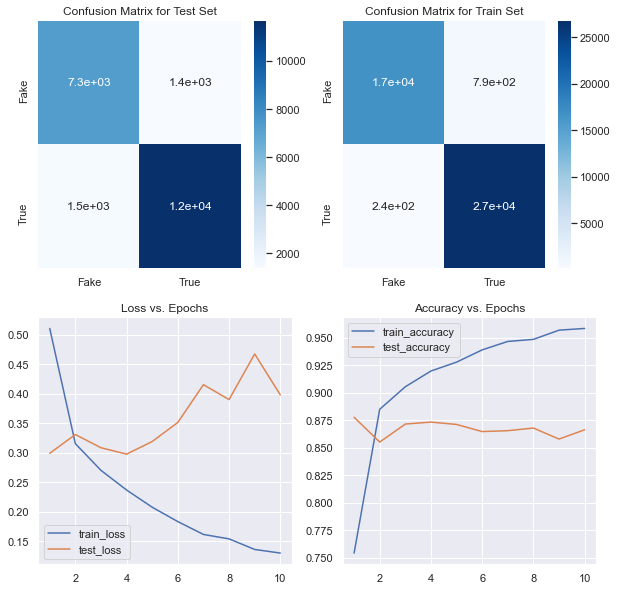

In [81]:
print_results(model_1, training_padded, y_train, testing_padded, y_test)

## Second Model

For the second model, we will not use LSTM layer but we will Flatten the output of the Embedding layer. In this model we will monitor validation loss for early stopping. By checking the final result, we see that this model is overfitted even though we used early stopping. 

In [82]:
callbacks = EarlyStopping(monitor = 'val_loss', patience = 2, mode = "min")

model_2 = Sequential()
model_2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 300, 128)          3840000   
_________________________________________________________________
flatten_12 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 50)                1920050   
_________________________________________________________________
dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 51        
Total params: 5,760,101
Trainable params: 5,760,101
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_2.fit(training_padded, y_train, epochs=10, batch_size=500,
         validation_data=(testing_padded, y_test), callbacks = [callbacks])

Epoch 1/10
89/89 [==============================] - 10s 115ms/step - loss: 0.4286 - accuracy: 0.8090 - val_loss: 0.2589 - val_accuracy: 0.8894
Epoch 2/10
89/89 [==============================] - 11s 125ms/step - loss: 0.1838 - accuracy: 0.9276 - val_loss: 0.2339 - val_accuracy: 0.9045
Epoch 3/10
89/89 [==============================] - 11s 119ms/step - loss: 0.1044 - accuracy: 0.9603 - val_loss: 0.2634 - val_accuracy: 0.8991
Epoch 4/10
89/89 [==============================] - 12s 133ms/step - loss: 0.0624 - accuracy: 0.9790 - val_loss: 0.3035 - val_accuracy: 0.8992


Fake      True  macro avg  weighted avg
data  index                                                 
TEST  precision      0.90      0.90       0.90          0.90
      recall         0.84      0.94       0.89          0.90
      f1-score       0.87      0.92       0.89          0.90
      support     8719.00  13194.00   21913.00      21913.00
TRAIN precision      0.99      0.99       0.99          0.99
      recall         0.98      1.00       0.99          0.99
      f1-score       0.99      0.99       0.99          0.99
      support    17502.00  26987.00   44489.00      44489.00

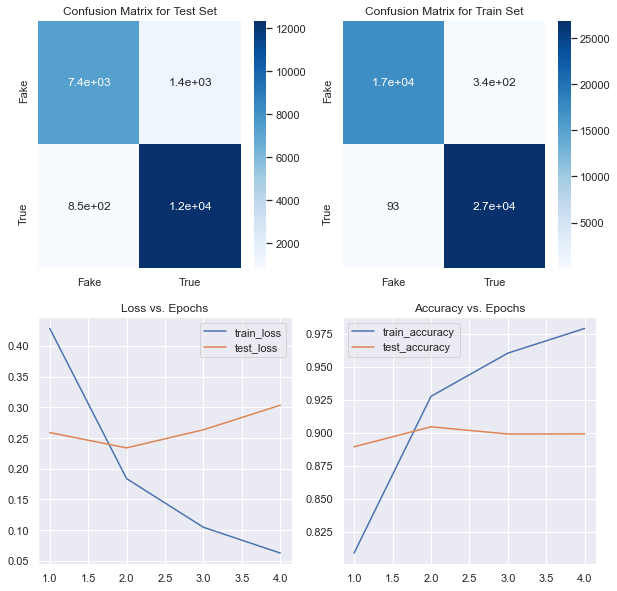

In [84]:
print_results(model_2, training_padded, y_train, testing_padded, y_test)

## 3rd Model

In the third neural network, we will use five dense layers after we flatten the out put of the LSTM layer. According to the diagrams we can see that this model is overfitted. 

In [93]:
model_3 = Sequential()


model_3.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_3.add(LSTM(20, return_sequences=True))
model_3.add(GlobalMaxPool1D())
model_3.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.5))
model_3.add(Dense(15, activation='relu'))
model_2.add(Dropout(0.5))
model_3.add(Dense(5, activation='relu'))
model_2.add(Dropout(0.5))
model_3.add(Dense(2, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_3.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 300, 128)          3840000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 300, 20)           11920     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 20)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_53 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_55 (Dense)             (None, 2)               

In [94]:
model_3.fit(training_padded, y_train, epochs=15, batch_size=500,
         validation_data=(testing_padded, y_test))

Epoch 1/15
89/89 [==============================] - 58s 647ms/step - loss: 0.6133 - accuracy: 0.7862 - val_loss: 0.5291 - val_accuracy: 0.8613
Epoch 2/15
89/89 [==============================] - 58s 652ms/step - loss: 0.4907 - accuracy: 0.8939 - val_loss: 0.4837 - val_accuracy: 0.8849
Epoch 3/15
89/89 [==============================] - 54s 607ms/step - loss: 0.4346 - accuracy: 0.9237 - val_loss: 0.4598 - val_accuracy: 0.8931
Epoch 4/15
89/89 [==============================] - 55s 622ms/step - loss: 0.3934 - accuracy: 0.9404 - val_loss: 0.4678 - val_accuracy: 0.8909
Epoch 5/15
89/89 [==============================] - 54s 607ms/step - loss: 0.3592 - accuracy: 0.9522 - val_loss: 0.4503 - val_accuracy: 0.8958
Epoch 6/15
89/89 [==============================] - 55s 623ms/step - loss: 0.3320 - accuracy: 0.9592 - val_loss: 0.4702 - val_accuracy: 0.8911
Epoch 7/15
89/89 [==============================] - 54s 609ms/step - loss: 0.3085 - accuracy: 0.9634 - val_loss: 0.4843 - val_accuracy: 0.8910

Fake      True  macro avg  weighted avg
data  index                                                 
TEST  precision      0.89      0.89       0.89          0.89
      recall         0.83      0.93       0.88          0.89
      f1-score       0.86      0.91       0.89          0.89
      support     8719.00  13194.00   21913.00      21913.00
TRAIN precision      1.00      0.96       0.98          0.97
      recall         0.93      1.00       0.97          0.97
      f1-score       0.96      0.98       0.97          0.97
      support    17502.00  26987.00   44489.00      44489.00

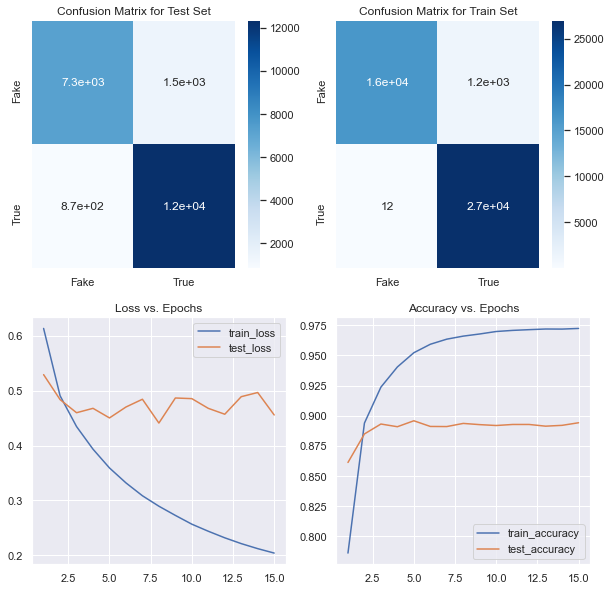

In [95]:
print_results(model_3, training_padded, y_train, testing_padded, y_test)

# Summary of Models

We can see that eventhough the accuracy scores of these models are better than some of the models introduced in other notebooks, but their recall scores are not as good as the logistic model or lightgbm. On the other hand, these models show significant overfitting. Therefore, these models are not reliable. One way to improve these models might be using optuna to optimize the hyperparameters of these models, or using embedded layers from other models. We will use that in the next notebook.